In [1]:
def slope_area_regression_binned(
    elev_obj,
    area_obj,
    fd_obj,
    min_area,
    vertical_interval=10,
    nbins=24,
    min_per_bin=10,
    agg="median",              # "median" (robust) or "mean"
    require_weighted=True,     # if True, use weighted LS on bin aggregates
    relax_if_sparse=True       # if too few bins survive, relax min_per_bin
):
    """
    Estimate channel steepness (k_s) and concavity (theta) using log-binned
    slope–area regression to avoid overweighting the numerous small-drainage pixels.

    Parameters
    ----------
    elev_obj : Elevation object
    area_obj : Area object
    fd_obj   : FlowDirectionD8 object
    min_area : float
        Minimum drainage area threshold (in same units as `area_obj`) for channel pixels.
    vertical_interval : int, default 10
        Vertical interval for ChannelSlopeWithSmoothing.
    nbins : int, default 24
        Number of equal-width bins in log10(A). 16–32 is typical.
    min_per_bin : int, default 10
        Minimum # of raw points required for a bin to be used.
    agg : {"median","mean"}, default "median"
        Aggregate statistic within each bin (of log10 S and log10 A).
    require_weighted : bool, default True
        Perform weighted least squares on binned points with weights = bin counts.
    relax_if_sparse : bool, default True
        If <3 bins pass the filter, progressively relax `min_per_bin` down to 3.

    Returns
    -------
    ks : float
        Channel steepness index (10**intercept in log10 space).
    theta : float
        Concavity (=-slope in log10 space).
    debug : dict
        Dictionary with arrays helpful for plotting/QA:
          - 'A' / 'S' : raw filtered arrays (1D)
          - 'logA'/'logS' : raw logs (1D)
          - 'bin_edges' : array (nbins+1,)
          - 'bin_centers' : array of used bin centers (log10 A)
          - 'bin_logA' : aggregated log10(A) per used bin
          - 'bin_logS' : aggregated log10(S) per used bin
          - 'bin_counts' : counts per used bin
    """
    # 1) Per-tile slope calculation (avoids NaN propagation from precomputed slopes)
    slope_obj = d.ChannelSlopeWithSmoothing(
        elevation=elev_obj, area=area_obj, flow_direction=fd_obj,
        vertical_interval=vertical_interval, min_area=min_area
    )

    S = slope_obj._griddata.flatten()
    A = area_obj._griddata.flatten()

    m = (A >= float(min_area)) & (S > 0) & np.isfinite(A) & np.isfinite(S)
    if np.count_nonzero(m) < 30:
        raise ValueError(f"Insufficient channel pixels after masking: {np.count_nonzero(m)} points")

    logA = np.log10(A[m])
    logS = np.log10(S[m])

    # 2) Define equal-width bins in log10(A)
    a_min, a_max = np.min(logA), np.max(logA)
    if not np.isfinite(a_min) or not np.isfinite(a_max) or a_min == a_max:
        raise ValueError("Degenerate drainage area range for binning.")

    bin_edges = np.linspace(a_min, a_max, nbins + 1)

    # 3) Aggregate by bin
    bin_logA, bin_logS, bin_counts = [], [], []
    for i in range(nbins):
        left, right = bin_edges[i], bin_edges[i + 1]
        # Include left edge, exclude right edge except on last bin
        idx = (logA >= left) & (logA < right) if i < nbins - 1 else (logA >= left) & (logA <= right)
        if np.count_nonzero(idx) < min_per_bin:
            continue

        if agg == "median":
            a_val = np.median(logA[idx])
            s_val = np.median(logS[idx])
        elif agg == "mean":
            a_val = np.mean(logA[idx])
            s_val = np.mean(logS[idx])
        else:
            raise ValueError("agg must be 'median' or 'mean'.")

        bin_logA.append(a_val)
        bin_logS.append(s_val)
        bin_counts.append(int(np.count_nonzero(idx)))

    # 4) If too few bins survive, optionally relax min_per_bin
    if relax_if_sparse and len(bin_logA) < 3:
        # Iteratively relax min_per_bin down to 3
        for target in [max(3, min_per_bin // 2), 3]:
            bin_logA, bin_logS, bin_counts = [], [], []
            for i in range(nbins):
                left, right = bin_edges[i], bin_edges[i + 1]
                idx = (logA >= left) & (logA < right) if i < nbins - 1 else (logA >= left) & (logA <= right)
                if np.count_nonzero(idx) < target:
                    continue
                if agg == "median":
                    a_val = np.median(logA[idx]); s_val = np.median(logS[idx])
                else:
                    a_val = np.mean(logA[idx]);   s_val = np.mean(logS[idx])
                bin_logA.append(a_val); bin_logS.append(s_val); bin_counts.append(int(np.count_nonzero(idx)))
            if len(bin_logA) >= 3:
                break

    if len(bin_logA) < 3:
        raise ValueError(
            f"Too few populated bins for regression (got {len(bin_logA)}). "
            "Consider lowering min_area, reducing nbins, or relaxing min_per_bin."
        )

    bin_logA = np.asarray(bin_logA)
    bin_logS = np.asarray(bin_logS)
    w = np.asarray(bin_counts, dtype=float)

    # 5) Weighted least squares on binned aggregates
    # Fit: bin_logS = b0 + b1 * bin_logA  (b1 = slope, b0 = intercept)
    if require_weighted:
        wx = np.sum(w * bin_logA) / np.sum(w)
        wy = np.sum(w * bin_logS) / np.sum(w)
        num = np.sum(w * (bin_logA - wx) * (bin_logS - wy))
        den = np.sum(w * (bin_logA - wx) ** 2)
        if den == 0:
            raise RuntimeError("Zero variance in binned log10(A); cannot fit.")
        b1 = num / den
        b0 = wy - b1 * wx
    else:
        # Unweighted fallback (rarely needed)
        b1, b0 = np.polyfit(bin_logA, bin_logS, 1)

    ks = 10 ** b0
    theta = -b1

    debug = dict(
        A=A[m], S=S[m], logA=logA, logS=logS,
        bin_edges=bin_edges,
        bin_centers=0.5 * (bin_edges[:-1] + bin_edges[1:]),
        bin_logA=bin_logA, bin_logS=bin_logS, bin_counts=w
    )
    return ks, theta, debug


PROJECT_ROOT: /Users/scdobbs/Desktop/Folders/Active_manuscripts/Geomorph_project/2026_resubmission
DATA_ROOT   : /Users/scdobbs/Desktop/Folders/Active_manuscripts/Geomorph_project/2026_resubmission/Model_runs/data

Loaded grids for AP tile1:
  elev_orig      : (1015, 1015)
  elev_part      : (1015, 1015)
  elev_AD_no_opt : (1015, 1015)
  elev_AD_opt    : (1015, 1015)
  area           : (1015, 1015)

Tile: AP tile1
  ORIGINAL    : Ks = 1.128e+02 m, θ = 0.542, R² = 0.962
  AD no-opt   : Ks = 5.409e-01 m, θ = -0.070, R² = 0.033
  AD opt      : Ks = 4.355e+01 m, θ = 0.460, R² = 0.977
  PARTITIONED : Ks = 1.192e+02 m, θ = 0.553, R² = 1.000

Loaded grids for GM tile2:
  elev_orig      : (1000, 1000)
  elev_part      : (1000, 1000)
  elev_AD_no_opt : (1000, 1000)
  elev_AD_opt    : (1000, 1000)
  area           : (1000, 1000)

Tile: GM tile2
  ORIGINAL    : Ks = 2.488e+00 m, θ = 0.306, R² = 0.962
  AD no-opt   : Ks = 3.970e-01 m, θ = -0.065, R² = 0.205
  AD opt      : Ks = 1.666e+00 m, θ = 0.

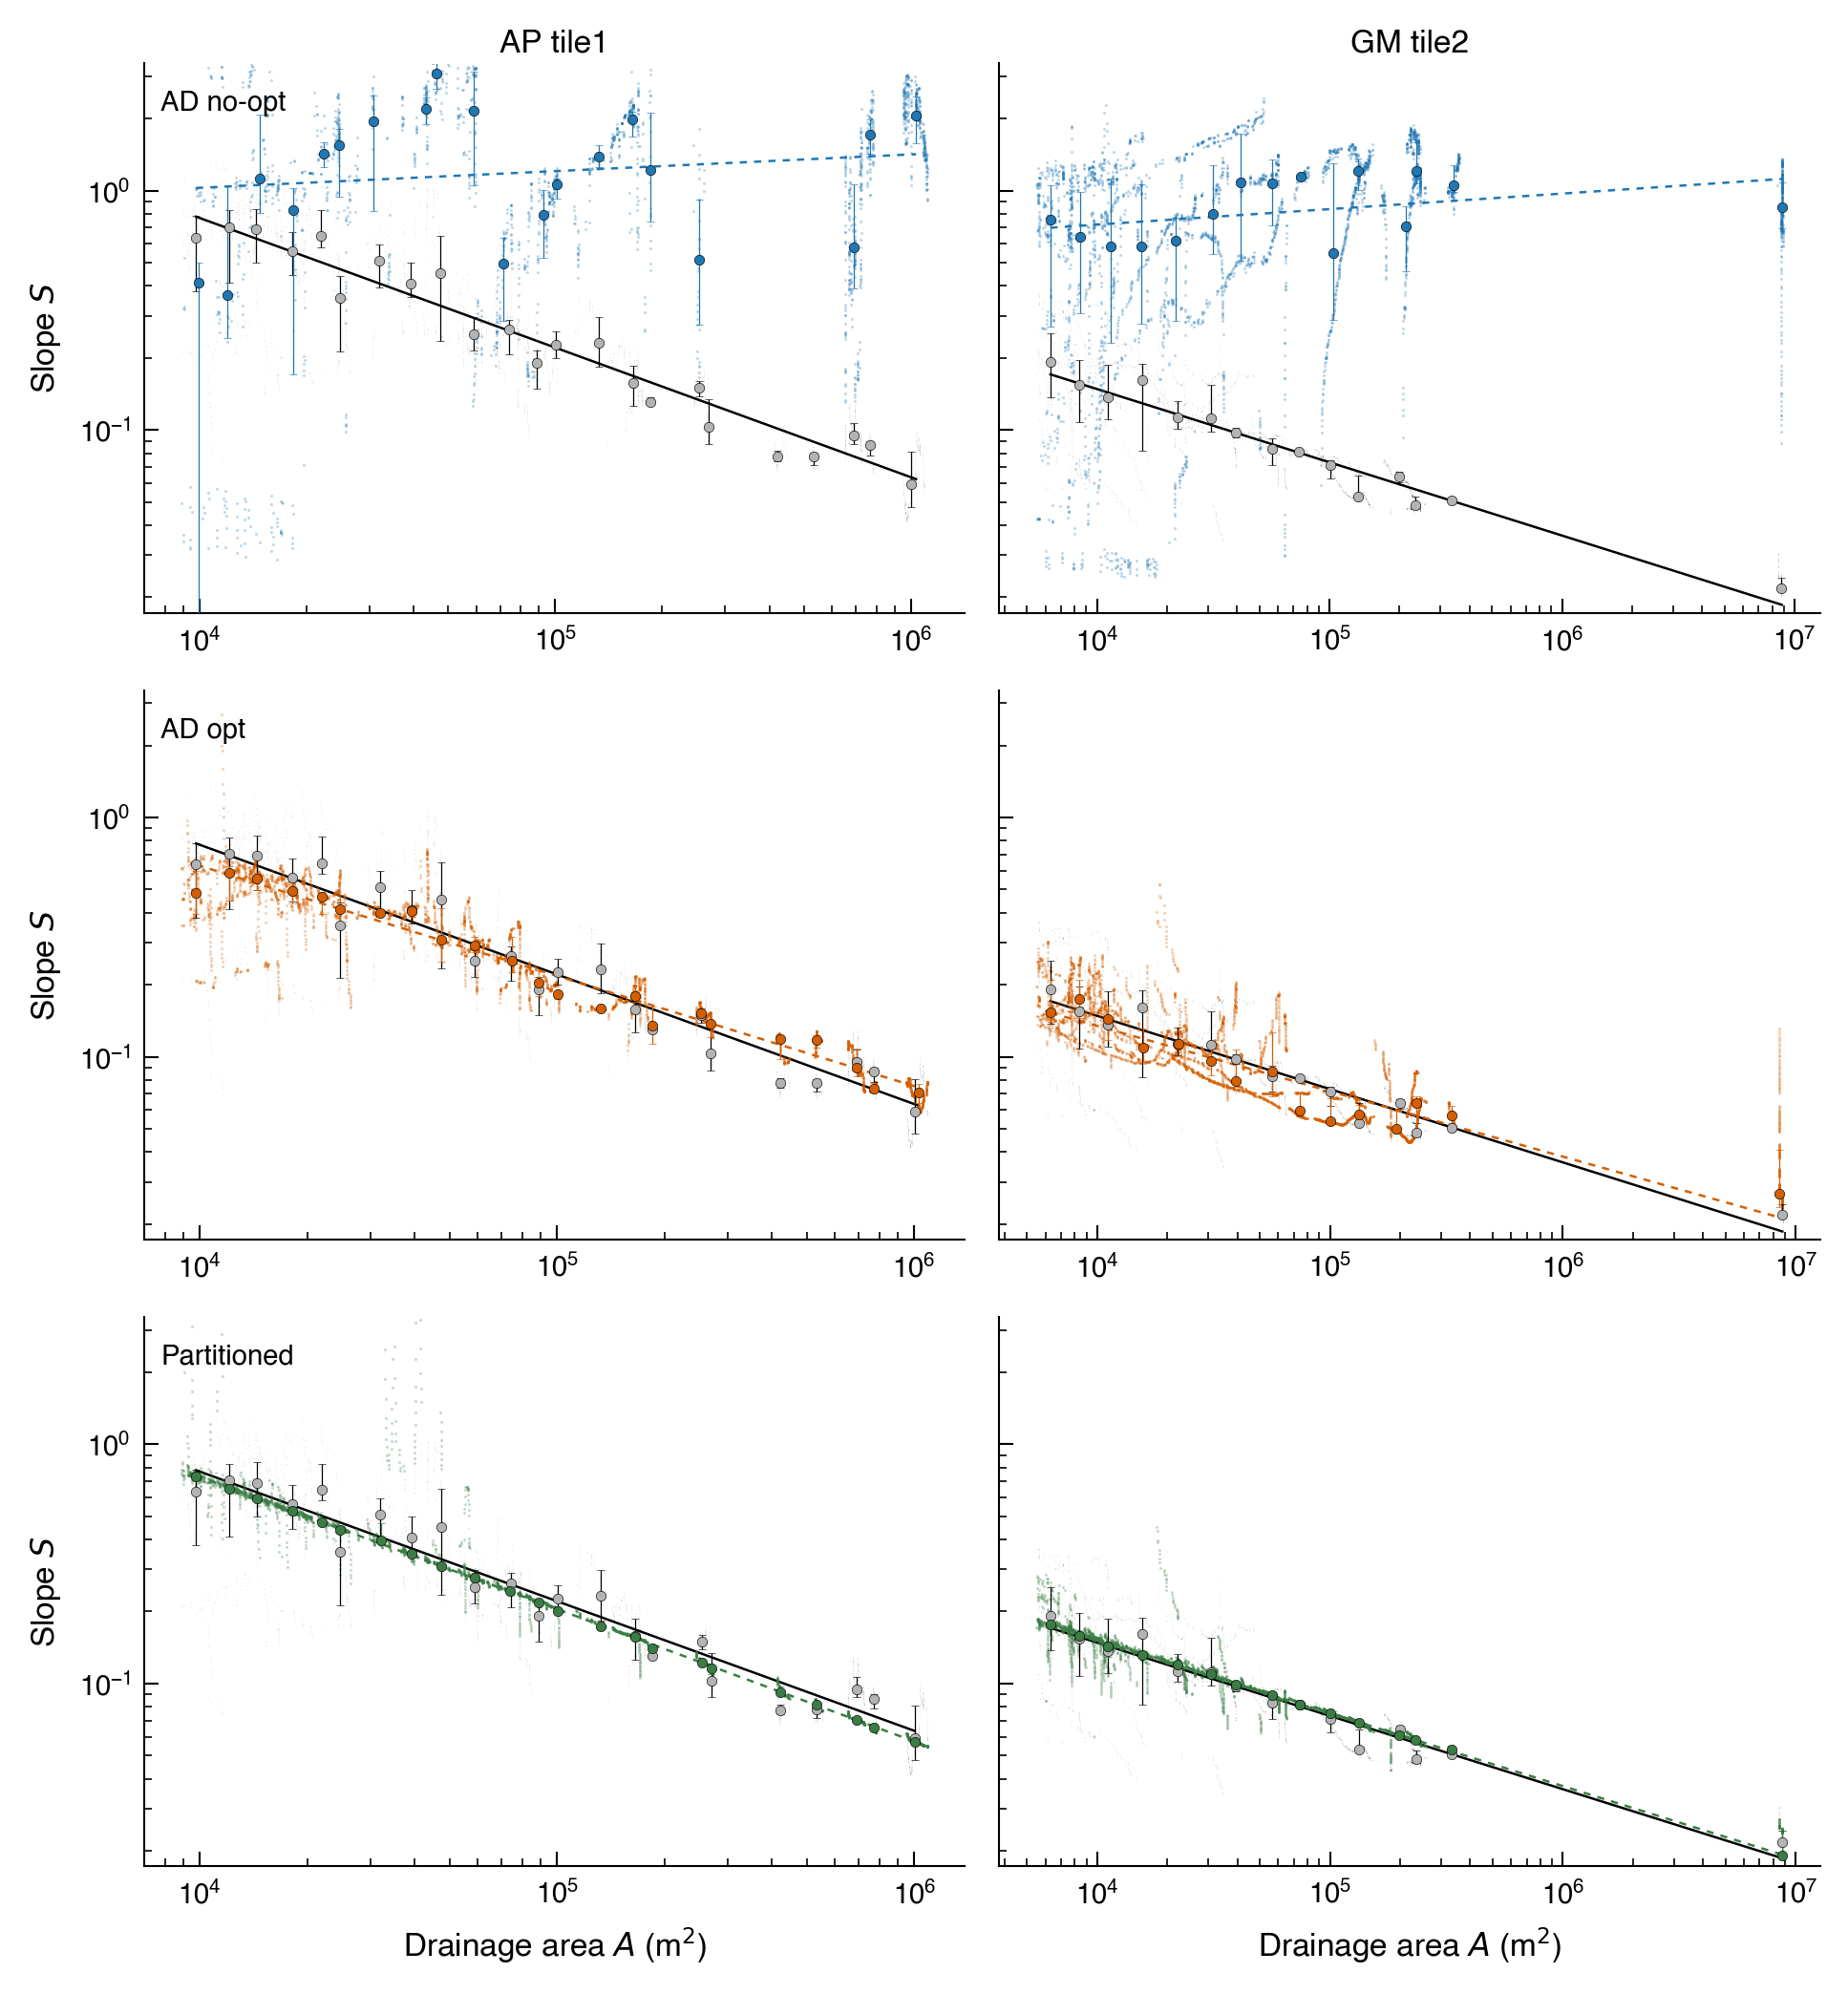

In [3]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator

from TopoAnalysis import dem as d


# ─────────────────────────────────────────────
# Matplotlib style (Nature-ish)
# ─────────────────────────────────────────────
plt.rcParams.update({
    "figure.dpi": 300,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "axes.linewidth": 0.5,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": False,
    "ytick.right": False,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.width": 0.4,
    "ytick.minor.width": 0.4,
    "savefig.bbox": "tight",
    "savefig.dpi": 300,
})

# ─────────────────────────────────────────────
# CONFIG FOR LOCATIONS / TILES
# ─────────────────────────────────────────────
LOC_CONFIGS = {
    "AP": {
        "tile_dir": "tile1", #change to any other tile to see other data
        "min_area": 8.89e3,
    },
    "GM": {
        "tile_dir": "tile2", #change to any other tile to see other data
        "min_area": 5.49e3,
    },
}

# Colors
GRAY_ORIG       = "0.25"
COLOR_PART      = "#3A7D44"   # green
COLOR_AD_NO_OPT = "#1f77b4"   # blue
COLOR_AD_OPT    = "#D55E00"   # orange

MEDIAN_EDGEWIDTH = 0.15  # thinner black outline on median markers


# ─────────────────────────────────────────────
# Path handling (portable): find project root containing data/
# ─────────────────────────────────────────────
def find_project_root(start=None, marker_dir="data"):
    """
    Walk upward from current working directory until we find a folder
    containing `marker_dir`. This makes the notebook portable across machines.
    """
    start = Path(start or Path.cwd()).resolve()
    for parent in [start, *start.parents]:
        if (parent / marker_dir).is_dir():
            return parent
    raise FileNotFoundError(
        f"Could not find '{marker_dir}/' by searching upward from:\n  {start}\n"
        f"Make sure this notebook is somewhere inside the repository folder tree."
    )

PROJECT_ROOT = find_project_root()
DATA_ROOT = PROJECT_ROOT / "data"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT   :", DATA_ROOT)

# ─────────────────────────────────────────────
# Helpers: unpack, IQR errors, R²
# ─────────────────────────────────────────────
def unpack_dbg(dbg):
    A_raw = dbg["A"]
    S_raw = dbg["S"]
    bA    = dbg["bin_logA"]
    bS    = dbg["bin_logS"]
    bN    = dbg["bin_counts"]
    A_bin = 10**bA
    S_bin = 10**bS
    return A_raw, S_raw, bA, bS, bN, A_bin, S_bin

def compute_iqr_errors(dbg):
    """
    Compute vertical IQR-based error bars (25–75% range) for each bin.
    Bin edges are reconstructed from bin_logA centers.
    """
    A = dbg["A"]
    S = dbg["S"]
    bA = dbg["bin_logA"]   # log10 centers

    nb = len(bA)
    centers_log = bA

    # Build edges in log10-space
    edges_log = np.empty(nb + 1, dtype=float)
    edges_log[1:-1] = 0.5 * (centers_log[:-1] + centers_log[1:])
    edges_log[0]  = centers_log[0]  - (edges_log[1]  - centers_log[0])
    edges_log[-1] = centers_log[-1] + (centers_log[-1] - edges_log[-2])

    edges = 10**edges_log

    lower_err = []
    upper_err = []

    for i in range(nb):
        a0, a1 = edges[i], edges[i+1]
        mask = (A >= a0) & (A < a1)
        svals = S[mask]

        if np.sum(mask) < 3:
            lower_err.append(0.0)
            upper_err.append(0.0)
            continue

        q25 = np.percentile(svals, 25)
        q75 = np.percentile(svals, 75)
        med = np.median(svals)

        lower_err.append(med - q25)
        upper_err.append(q75 - med)

    return np.array(lower_err), np.array(upper_err)

def weighted_r2(x, y, yhat, w):
    ybar = np.sum(w * y) / np.sum(w)
    SS_res = np.sum(w * (y - yhat)**2)
    SS_tot = np.sum(w * (y - ybar)**2)
    return 1 - SS_res / SS_tot


# ─────────────────────────────────────────────
# Load + run regressions for one location
# ─────────────────────────────────────────────
def prepare_location(location, tile_dir, min_area,
                     vertical_interval=10, nbins=24):
    """
    Load original + three models for a given location/tile,
    run slope–area regression, return dict of results.

    Expected layout:
      data/<LOCATION>/<tile_dir>/
        - original grids (Elevation/Area/FD) live in this folder
        - modeled grids live in: .../outputs/
    """
    tile_path = DATA_ROOT / location / tile_dir
    outputs_path = tile_path / "outputs"

    # --- sanity checks that won't break portability ---
    if not tile_path.is_dir():
        raise FileNotFoundError(f"Missing tile directory: {tile_path}")
    if not outputs_path.is_dir():
        raise FileNotFoundError(f"Missing outputs directory: {outputs_path}")

    # Original grids (in tile_path)
    elev_prefix = f"{location}_1m_best_tile_filled"
    flow_prefix = f"{location}_1m_best_tile_fd"
    area_prefix = f"{location}_1m_best_tile_area"

    root_elev = str(tile_path / elev_prefix)
    root_flow = str(tile_path / flow_prefix)
    root_area = str(tile_path / area_prefix)

    elev_orig = d.Elevation.load(root_elev)
    area      = d.Area.load(root_area)
    fd        = d.FlowDirectionD8.load(root_flow)

    # Modeled grids (in outputs_path)
    prefix_part      = f"{location}_1m_best_tile_Partitioned-model-a_crit-k-d-opt"
    prefix_AD_no_opt = f"{location}_1m_best_tile_AD-no-opt"
    prefix_AD_opt    = f"{location}_1m_best_tile_AD-opt"

    elev_part      = d.FilledElevation.load(str(outputs_path / (prefix_part      + "_filled")))
    elev_AD_no_opt = d.FilledElevation.load(str(outputs_path / (prefix_AD_no_opt + "_filled")))
    elev_AD_opt    = d.FilledElevation.load(str(outputs_path / (prefix_AD_opt    + "_filled")))

    print(f"\nLoaded grids for {location} {tile_dir}:")
    print("  elev_orig      :", elev_orig._griddata.shape)
    print("  elev_part      :", elev_part._griddata.shape)
    print("  elev_AD_no_opt :", elev_AD_no_opt._griddata.shape)
    print("  elev_AD_opt    :", elev_AD_opt._griddata.shape)
    print("  area           :", area._griddata.shape)

    def run_reg(elev_obj):
        Ks, theta, dbg = slope_area_regression_binned(
            elev_obj=elev_obj,
            area_obj=area,
            fd_obj=fd,
            min_area=min_area,
            vertical_interval=vertical_interval,
            nbins=nbins,
            min_per_bin=10,
            agg="median",
            require_weighted=True,
            relax_if_sparse=True,
        )
        # R² in log–log space
        bA = dbg["bin_logA"]
        bS = dbg["bin_logS"]
        bN = dbg["bin_counts"].astype(float)
        yhat = np.log10(Ks) - theta * bA
        R2 = weighted_r2(bA, bS, yhat, bN)
        return Ks, theta, R2, dbg

    Ks_o, th_o, R2_o, dbg_o = run_reg(elev_orig)
    Ks_n, th_n, R2_n, dbg_n = run_reg(elev_AD_no_opt)
    Ks_f, th_f, R2_f, dbg_f = run_reg(elev_AD_opt)
    Ks_p, th_p, R2_p, dbg_p = run_reg(elev_part)

    print(f"\nTile: {location} {tile_dir}")
    print(f"  ORIGINAL    : Ks = {Ks_o:.3e} m, θ = {th_o:.3f}, R² = {R2_o:.3f}")
    print(f"  AD no-opt   : Ks = {Ks_n:.3e} m, θ = {th_n:.3f}, R² = {R2_n:.3f}")
    print(f"  AD opt      : Ks = {Ks_f:.3e} m, θ = {th_f:.3f}, R² = {R2_f:.3f}")
    print(f"  PARTITIONED : Ks = {Ks_p:.3e} m, θ = {th_p:.3f}, R² = {R2_p:.3f}")

    return {
        "orig":      dict(Ks=Ks_o, theta=th_o, R2=R2_o, dbg=dbg_o),
        "AD_no_opt": dict(Ks=Ks_n, theta=th_n, R2=R2_n, dbg=dbg_n),
        "AD_opt":    dict(Ks=Ks_f, theta=th_f, R2=R2_f, dbg=dbg_f),
        "part":      dict(Ks=Ks_p, theta=th_p, R2=R2_p, dbg=dbg_p),
    }


# ─────────────────────────────────────────────
# Prepare both locations
# ─────────────────────────────────────────────
results = {}
for loc, cfg in LOC_CONFIGS.items():
    results[loc] = prepare_location(loc, cfg["tile_dir"], cfg["min_area"])


# ─────────────────────────────────────────────
# Compute global Y-limits from binned S across all 6 panels
# ─────────────────────────────────────────────
Smins, Smaxs = [], []
for loc in ["AP", "GM"]:
    res_loc = results[loc]
    dbg_o = res_loc["orig"]["dbg"]
    _, _, _, _, _, _, S_bin_o = unpack_dbg(dbg_o)
    for model_key in ["AD_no_opt", "AD_opt", "part"]:
        dbg_m = res_loc[model_key]["dbg"]
        _, _, _, _, _, _, S_bin_m = unpack_dbg(dbg_m)
        Smins.append(np.nanmin(S_bin_o))
        Smins.append(np.nanmin(S_bin_m))
        Smaxs.append(np.nanmax(S_bin_o))
        Smaxs.append(np.nanmax(S_bin_m))

global_ymin = min(Smins) * 0.9
global_ymax = max(Smaxs) * 1.1


# ─────────────────────────────────────────────
# 2×3 FIGURE: rows = models, cols = AP / GM
# ─────────────────────────────────────────────
fig, axes = plt.subplots(
    nrows=3, ncols=2,
    figsize=(6.5, 7.0),
    sharey=True,
)

row_model_keys = ["AD_no_opt", "AD_opt", "part"]
row_labels     = ["AD no-opt", "AD opt", "Partitioned"]
col_locations  = ["AP", "GM"]

for col, loc in enumerate(col_locations):
    tile_dir = LOC_CONFIGS[loc]["tile_dir"]
    res_loc = results[loc]

    for row, (model_key, row_label) in enumerate(zip(row_model_keys, row_labels)):
        ax = axes[row, col]

        orig = res_loc["orig"]
        mod  = res_loc[model_key]

        print(f"\n{loc} {tile_dir} – {row_label}")
        print(f"  ORIG: Ks = {orig['Ks']:.3e}, θ = {orig['theta']:.3f}, R² = {orig['R2']:.3f}")
        print(f"  {row_label}: Ks = {mod['Ks']:.3e}, θ = {mod['theta']:.3f}, R² = {mod['R2']:.3f}")

        dbg_o = orig["dbg"]
        dbg_m = mod["dbg"]

        A_raw_o, S_raw_o, bA_o, bS_o, bN_o, A_bin_o, S_bin_o = unpack_dbg(dbg_o)
        A_raw_m, S_raw_m, bA_m, bS_m, bN_m, A_bin_m, S_bin_m = unpack_dbg(dbg_m)

        err_lo_o, err_hi_o = compute_iqr_errors(dbg_o)
        err_lo_m, err_hi_m = compute_iqr_errors(dbg_m)

        # Fits: A-range from orig + model
        logA_min = min(np.nanmin(bA_o), np.nanmin(bA_m))
        logA_max = max(np.nanmax(bA_o), np.nanmax(bA_m))
        A_fit = np.logspace(logA_min, logA_max, 200)
        S_fit_o = orig["Ks"] * A_fit**(-orig["theta"])
        S_fit_m = mod["Ks"]  * A_fit**(-mod["theta"])

        # Choose model color
        if model_key == "AD_no_opt":
            color_model = COLOR_AD_NO_OPT
        elif model_key == "AD_opt":
            color_model = COLOR_AD_OPT
        else:
            color_model = COLOR_PART

        # --------- PLOTTING ----------
        ax.loglog(
            A_raw_o, S_raw_o,
            'o',
            markersize=0.2,
            alpha=0.15,
            color=GRAY_ORIG,
            markeredgewidth=0.0,
            markeredgecolor="none",
            rasterized=True,
        )

        ax.errorbar(
            A_bin_o, S_bin_o,
            yerr=[err_lo_o, err_hi_o],
            fmt='o',
            markersize=2.5,
            mfc="0.7",
            mec="black",
            mew=MEDIAN_EDGEWIDTH,
            ecolor="black",
            elinewidth=0.3,
            capsize=1.0,
            zorder=3,
        )

        ax.loglog(
            A_fit, S_fit_o,
            color="black",
            lw=0.6,
        )

        ax.loglog(
            A_raw_m, S_raw_m,
            'o',
            markersize=0.7,
            alpha=0.3,
            color=color_model,
            markeredgewidth=0.0,
            markeredgecolor="none",
            rasterized=True,
        )

        ax.errorbar(
            A_bin_m, S_bin_m,
            yerr=[err_lo_m, err_hi_m],
            fmt='o',
            markersize=2.5,
            mfc=color_model,
            mec="black",
            mew=MEDIAN_EDGEWIDTH,
            ecolor=color_model,
            elinewidth=0.3,
            capsize=1.0,
            zorder=3,
        )

        ax.loglog(
            A_fit, S_fit_m,
            color=color_model,
            lw=0.6,
            linestyle=(0, (3, 3)),
        )

        # Axes settings
        ax.xaxis.set_major_locator(LogLocator(base=10))
        ax.yaxis.set_major_locator(LogLocator(base=10))
        ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
        ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
        ax.minorticks_on()

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.set_ylim(global_ymin, global_ymax)

        if row == 0:
            ax.set_title(f"{loc} {tile_dir}", pad=3)

        if col == 0:
            ax.text(
                0.02, 0.95, row_label,
                transform=ax.transAxes,
                ha="left", va="top",
                fontsize=7,
            )

        if row == 2:
            ax.set_xlabel(r"Drainage area $A$ (m$^2$)")
        else:
            ax.set_xlabel("")

        if col == 0:
            ax.set_ylabel(r"Slope $S$")
        else:
            ax.set_ylabel("")

fig.tight_layout()
plt.show()
